In [1]:
from geosdm.dataprocessing import ecological_info
from geosdm.dataprocessing import hydinfo
from geosdm.dataprocessing import landcover
from geosdm.dataprocessing import sedi_info
from geosdm.dataprocessing import water_quality_info
from geosdm.dataprocessing import weather
from geosdm.dataprocessing import datacontroller

from glob import glob
import rasterio
import os
from rasterio.merge import merge
import rioxarray
import geopandas as gpd 
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from shapely.geometry import Point
from pyproj import Proj, transform
from rasterstats import zonal_stats

In [2]:
data_path_list = os.getcwd().split(os.path.sep) + ['data']
data_path = os.path.sep.join(data_path_list)
use_cleaned_dataset = True


controller = datacontroller.DataContorller(data_path, use_cleaned_dataset)
controller.get_merged_set('name')

c:\Users\rhqud\AppData\Local\Programs\Python\Python38\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\rhqud\repos\geo_sdm\geosdm\dataprocessing\weather.py:172: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calling .quantile, select only columns which should be valid for the function.
  q1_df = atm_df_filter_1.groupby('지점명').quantile([0.25]).set_index(mean_df.index)
c:\Users\rhqud\repos\geo_sdm\geosdm\dataprocessing\weather.py:174: FutureWarning: Dropping invalid columns in DataFrameGroupBy.quantile is deprecated. In a future version, a TypeError will be raised. Before calli

In [3]:
controller._final_set.to_csv('name.csv', encoding='euc-kr')

* 피팅

In [ ]:
sub_cols = [
'유량',
'cate_1', 'cate_2', 'cate_3', 'cate_4', 'cate_5', 'cate_6', 'cate_7', 'elevation', 'slope',
'일강수량(mm)', '평균기온(°C)', '합계 일조시간(hr)', '일강수량(mm)_q1', '평균기온(°C)_q1', '합계 일조시간(hr)_q1', '일강수량(mm)_q3', '평균기온(°C)_q3', '합계 일조시간(hr)_q3'

]
subset_df = controller._final_set.loc[:,sub_cols]
subset_df = subset_df.dropna()

In [38]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import shap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [30]:
y = subset_df.iloc[:,0]
X = subset_df.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [48]:
# rand_reg = RandomForestRegressor(random_state=42, max_depth=3, n_estimators=300)
# space_xgb = [hp.uniform('learn',0.01,0.8),           
#          hp.quniform('nesti',100,350,q=10),          
#          hp.quniform('maxd',3,8,q=1),                
#          hp.quniform('minc',  1,10,q=1),             
#          hp.uniform('gamm',  0.1,3),              
#          hp.uniform('subsa',  0.5,1),
#          hp.uniform('colsample_b',  0.6,0.9),
#          #hp.quniform('scalepos',  0.8,1.2,q=0.1)
#          #hp.quniform('times',  0,6,q=1)
#          ]

rand_reg = xgb.XGBRegressor(
        learning_rate =0.01,
        n_estimators=500,
        max_depth=10,
        min_child_weight=3,
        gamma=0.5,
        subsample=0.6,
        colsample_bytree=0.7,
        # scale_pos_weight=scalepos,
        #seed=seed_value,
        n_jobs = -1,
        seed = 100)
rand_reg.fit(X_train, y_train.ravel())

y_pred_train = rand_reg.predict(X_train)
y_pred = rand_reg.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train, squared= True)
test_mse = mean_squared_error(y_test, y_pred, squared= True)

train_rmse = mean_squared_error(y_train, y_pred_train, squared= False)
test_rmse = mean_squared_error(y_test, y_pred, squared= False)

train_r2 = r2_score(y_train, y_pred_train,)
test_r2 = r2_score(y_test, y_pred,)

print(train_mse, test_mse, train_rmse, test_rmse, train_r2, test_r2)

3326.1348258671037 9822.45605332428 57.67265232211107 99.10830466375802 0.9142923627089218 0.7195381765479276


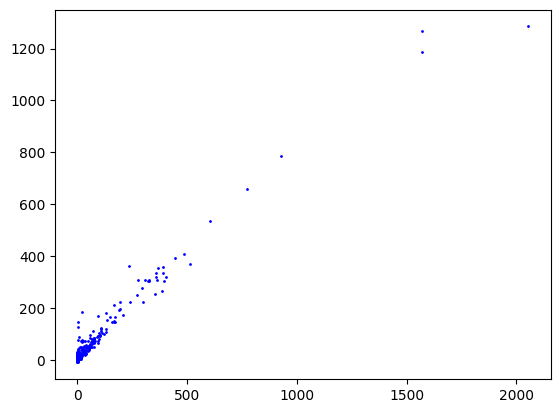

In [49]:
plt.plot(y_train, y_pred_train, 'bo', markersize = 1)

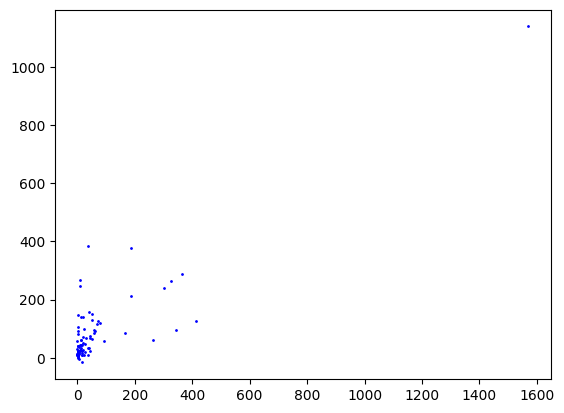

In [50]:
plt.plot(y_test, y_pred, 'bo', markersize = 1)

In [ ]:
shap_values = shap.TreeExplainer(ind_val[10]).shap_values(X)
shap.summary_plot(shap_base.reshape(-1,119), reshape_input, feature_names=col_names,show=False,max_display=20)


* CAT-DID로 KRF자료 이미 주어져있음
* 상하류 DID 정보?
* 전체 소하천 KRF에 생물측정망을 붙여야할지 고민
* 하상정보? 병합